In [ ]:
!nvidia-smi # Check whether your system has a GPU

# Import packages

In [35]:
import numpy as np
import cv2
import torch 
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F

numpy 
- A scientific computing library
- Supports array operations and manipulations
- Built-in functions like array sum, diff, mean, average, min, max etc.

cv2
- To read and write images
- To perform basic vision algorithms like RGB to HSV, Gaussian Blur, Dilation, Histogram, Shape detection etc.

torch
- The open source ML framework for deep learning
- Has a pythonic interface

torchvision
- consists of popular datasets, model architectures, and common image transformations for computer vision
- Contains built in data augmentations

matplotlib
- It is a data visualization library for python
- It supports graphical plotting and viewing images and other data

nn
- The base module with which we can create and train neural nets
- Provides built-in classes for common neural network layers like Conv, Pooling, Activations, Normalizations, Dropout etc.

optim
- It is a package for implementing various optimization algorithms for model training
- Built-in optimizers like SGD, Adam, Adagrad, RMSprop etc.

# Preprocess inputs

In [36]:
transform = transforms.Compose([transforms.ToTensor()]) # Define the set of transformations to be applied on the input data

In [37]:
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

ToTensor()
 - converts the image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0]

Normalize() 
- output[channel] = (input[channel] - mean[channel]) / std[channel]

- Normalization helps get data within a range and reduces the skewness which helps learn faster and better. 
- Normalization can also tackle the diminishing and exploding gradients problems.

# Create Dataloaders

- Combines a dataset and a sampler
- Provides an iterable over the given dataset
- Supports single- or multi-process loading
- Customizing loading order
- Automatic batching

In [38]:
trainset = datasets.CIFAR10('trainset', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [39]:
valset = datasets.CIFAR10('testset', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [40]:
dataiter = iter(trainloader)

Now that we have an iterator, let's visualize our data

In [41]:
images, gt_labels = dataiter.next() # The first minibatch of data

In [42]:
print(images.shape)
print(gt_labels.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


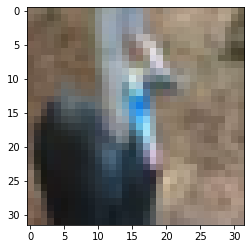

In [43]:
 # Visualize an image sample
plt.imshow((images[2].squeeze()).permute(1,2,0).numpy())

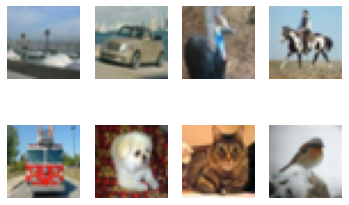

In [44]:
# Visualize all images in the minibatch
figure = plt.figure()
total_samples = 8
for index in range(1,total_samples+1):
    plt.subplot(2, 4, index)
    plt.axis('off')
    plt.imshow(images[index-1].squeeze().permute(1,2,0).numpy())

In [45]:
# Visualize the Ground truth labels
print(gt_labels)

tensor([8, 1, 2, 7, 9, 5, 3, 2, 8, 9, 8, 1, 9, 4, 5, 2, 6, 7, 3, 0, 9, 9, 2, 1,
        1, 8, 5, 6, 6, 3, 3, 2])


In [46]:
# Visualize the onehot encoding of the labels
onehot_labels = nn.functional.one_hot(gt_labels, num_classes=10)
print(onehot_labels)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],


# Let's build our AlexNet

![](assets/AlexNet.jpeg)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        print(x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
model = AlexNet()
x = model(torch.randn(1,3,1000,1000))
print(x.shape)

### Create a Model for CIFAR-10 Classification

In [47]:
class CIFARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
model = CIFARModel()

In [49]:
print(model)

CIFARModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [50]:
model_inputs = images
model_inputs.shape

torch.Size([32, 3, 32, 32])

In [51]:
# The model predicts the probability of each class for each input
pred_probs = model(model_inputs)
print(pred_probs.shape)

torch.Size([32, 10])


In [52]:
# print the probability values
print(pred_probs)

tensor([[ 0.0278, -0.0895,  0.0309,  0.1201,  0.0918,  0.0418,  0.1024, -0.0814,
          0.0448,  0.0828],
        [ 0.0274, -0.0910,  0.0293,  0.1221,  0.0912,  0.0408,  0.1038, -0.0808,
          0.0466,  0.0816],
        [ 0.0288, -0.0899,  0.0290,  0.1246,  0.0920,  0.0430,  0.1020, -0.0776,
          0.0439,  0.0814],
        [ 0.0310, -0.0883,  0.0278,  0.1199,  0.0908,  0.0416,  0.0970, -0.0829,
          0.0463,  0.0840],
        [ 0.0283, -0.0923,  0.0326,  0.1203,  0.0893,  0.0394,  0.1015, -0.0815,
          0.0452,  0.0808],
        [ 0.0302, -0.0876,  0.0310,  0.1255,  0.0946,  0.0387,  0.0996, -0.0809,
          0.0462,  0.0838],
        [ 0.0239, -0.0973,  0.0312,  0.1212,  0.0895,  0.0432,  0.1037, -0.0816,
          0.0449,  0.0809],
        [ 0.0283, -0.0906,  0.0303,  0.1193,  0.0891,  0.0364,  0.1010, -0.0817,
          0.0481,  0.0822],
        [ 0.0268, -0.0871,  0.0294,  0.1199,  0.0912,  0.0432,  0.1023, -0.0823,
          0.0452,  0.0828],
        [ 0.0262, -

In [53]:
# confirm that the probability values sums to 1
print(pred_probs.sum(dim=-1))

tensor([0.3714, 0.3712, 0.3770, 0.3673, 0.3635, 0.3809, 0.3598, 0.3624, 0.3713,
        0.3705, 0.3688, 0.3620, 0.3691, 0.3857, 0.3663, 0.3649, 0.3646, 0.3695,
        0.3667, 0.3700, 0.3686, 0.3741, 0.3750, 0.3654, 0.3729, 0.3719, 0.3676,
        0.3710, 0.3653, 0.3652, 0.3748, 0.3637], grad_fn=<SumBackward1>)


Visualize the probabilities of a sample image

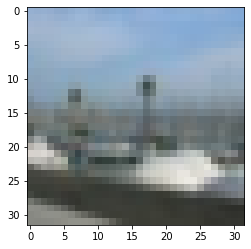

In [55]:
# see a sample image
plt.imshow(images[0].squeeze().permute(1,2,0).numpy())

In [56]:
# print the ground truth label
print(gt_labels[0])

tensor(8)


In [57]:
# print the ground truth onehot representation
print(onehot_labels[0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


In [58]:
# print the predicted probabilities for the sample image
print(pred_probs[0])

tensor([ 0.0278, -0.0895,  0.0309,  0.1201,  0.0918,  0.0418,  0.1024, -0.0814,
         0.0448,  0.0828], grad_fn=<SelectBackward0>)


In [59]:
# print the predicted class number for the sample image
print(torch.argmax(pred_probs[0], dim=-1))

tensor(3)


In [60]:
# print the ground truth labels of the minibatch
print(gt_labels)

tensor([8, 1, 2, 7, 9, 5, 3, 2, 8, 9, 8, 1, 9, 4, 5, 2, 6, 7, 3, 0, 9, 9, 2, 1,
        1, 8, 5, 6, 6, 3, 3, 2])


In [61]:
# print the predicted labels of the minibatch
print(torch.argmax(pred_probs, dim=-1))

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])


In [62]:
criterion = nn.CrossEntropyLoss()

# Model Training

Initialize the optimizer, total epochs etc.

In [65]:
model = CIFARModel().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 4
pbar = tqdm(range(epochs))

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
range(len(trainloader))

In [ ]:
time_init = time() # record the time at which training started

for e in range(epochs):
    running_loss = 0
    for images, gt_labels in tqdm(trainloader):
        # images, gt_labels = next(trainloader)
        images = images.cuda()
        gt_labels = gt_labels.cuda()
        # Training pass
        optimizer.zero_grad() # reset the gradients of model weights
        
        output = model(images)
        loss = criterion(output, gt_labels)
        
        # Calculate the gradients of the learnable parameters
        loss.backward()
        
        # Modify the model weights as per the gradients
        optimizer.step()
        
        running_loss += loss.item()

    average_loss = running_loss/len(trainloader)
    print(f"Epoch {e} - Training loss: {average_loss}\n")
print(f"Training Time (in minutes) = {(time()-time_init)/60}")

# Model Validation

In [68]:
images, gt_labels = next(iter(valloader))

with torch.no_grad():
    pred_probs = model(images.cuda())

predicted_labels = torch.argmax(pred_probs, dim=-1)

Lets visualize the validation input images

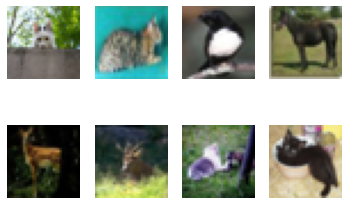

In [69]:
# Visualize all images in the minibatch
figure = plt.figure()
total_samples = 8
for index in range(1,total_samples+1):
    plt.subplot(2, 4, index)
    plt.axis('off')
    plt.imshow(images[index-1].squeeze().permute(1,2,0).numpy())

Ground truth class labels

In [70]:
print(f"Ground truth labels : {gt_labels}")

Ground truth labels : tensor([3, 3, 2, 7, 4, 4, 3, 3, 4, 6, 0, 2, 0, 3, 9, 3, 7, 8, 5, 4, 6, 8, 1, 1,
        9, 9, 5, 4, 5, 5, 7, 4])


Predicted class labels

In [71]:
print(f"Predicted labels : {predicted_labels}",)

Predicted labels : tensor([2, 3, 3, 7, 4, 4, 1, 5, 4, 6, 7, 3, 4, 4, 9, 3, 3, 8, 5, 2, 6, 8, 1, 3,
        9, 9, 3, 4, 5, 4, 7, 4], device='cuda:0')


Calculate the accuracy for the minibatch of validation data

In [72]:
correct_count = 0
total_count = 0
for i in range(len(gt_labels)):
  img = images[i]
  if predicted_labels[i]==gt_labels[i]:
    correct_count = correct_count+1
  total_count = total_count+1
accuracy = correct_count/total_count
print(f"The accuracy on the minibatch is : {accuracy}")

The accuracy on the minibatch is : 0.59375


Lets go through all the validation images and calculate the overall accuracy

In [73]:
correct_count = 0
total_count = 0

for images,gt_labels in valloader:
  pred_probs = model(images.cuda())
  predicted_labels = torch.argmax(pred_probs, dim=-1)

  for i in range(len(gt_labels)):
    if predicted_labels[i]==gt_labels[i]:
      correct_count = correct_count+1
    total_count = total_count+1       

accuracy = correct_count/total_count
print(f"Number of validation images = {total_count}\n")
print(f"Model Accuracy = {accuracy}")

Number of validation images = 10000

Model Accuracy = 0.5979


In [ ]:
torch.save(model, './first_mnist_model.pt') 

# Better Training Loops

- Add a progress bar for the training
- After each epoch, validate the model to see if the model has converged or whether it is overfit


In [66]:
# model = create_model()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 100
pbar = tqdm(range(epochs))
best_accuracy = 0.0

  0%|          | 0/4 [00:16<?, ?it/s]


In [ ]:
time_init = time() # record the time at which training started

for e in pbar:
    running_loss = 0
    for images, gt_labels in tqdm(trainloader):
        # Flatten MNIST images into a 784 long vector
        images = images.cuda()
        gt_labels = gt_labels.cuda()
    
        # Training pass
        optimizer.zero_grad() # reset the gradients of model weights
        
        output = model(images)
        loss = criterion(output, gt_labels)
        
        # Calculate the gradients of the learnable parameters
        loss.backward()
        
        # Modify the model weights as per the gradients
        optimizer.step()
        
        running_loss += loss.item()
    average_loss = running_loss/len(trainloader)
    
    # perform validation
    correct_count = 0
    total_count = 0
    for images,gt_labels in valloader:
      pred_probs = model(images.cuda())
      predicted_labels = torch.argmax(pred_probs, dim=-1)

      for i in range(len(gt_labels)):
        if predicted_labels[i]==gt_labels[i]:
          correct_count = correct_count+1
        total_count = total_count+1       

    accuracy = correct_count/total_count
    
    # save the model weights
    if accuracy>=best_accuracy:
      best_accuracy = accuracy
      torch.save(model, './best_mnist_model.pt')
    torch.save(model, './best_mnist_model.pt') 

    print(f"\nEpoch {e} - Training loss: {average_loss}, val accuracy : {accuracy}")
print(f"Training Time (in minutes) = {(time()-time_init)/60}")

# Visualize the training progress

Lets visualize the trend of loss and accuracies over the course of the model training

In [ ]:
# only for Google colab
%load_ext tensorboard
%tensorboard --logdir=runs --load_fast=false

In [ ]:
from torch.utils.tensorboard import SummaryWriter
summary_writer = SummaryWriter()

In [ ]:
model = create_model()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 100
pbar = tqdm(range(epochs))
best_accuracy = 0.0

In [ ]:
time_init = time() # record the time at which training started

for e in pbar:
    running_loss = 0
    for images, gt_labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad() # reset the gradients of model weights
        
        output = model(images)
        loss = criterion(output, gt_labels)
        
        # Calculate the gradients of the learnable parameters
        loss.backward()
        
        # Modify the model weights as per the gradients
        optimizer.step()
        
        running_loss += loss.item()
    average_loss = running_loss/len(trainloader)
    
    # perform validation
    correct_count = 0
    total_count = 0
    for images,gt_labels in valloader:
      pred_probs = model(images.view(images.shape[0], -1))
      predicted_labels = torch.argmax(pred_probs, dim=-1)

      for i in range(len(gt_labels)):
        if predicted_labels[i]==gt_labels[i]:
          correct_count = correct_count+1
        total_count = total_count+1       

    accuracy = correct_count/total_count

    # save the model weights
    if accuracy>=best_accuracy:
      best_accuracy = accuracy
      torch.save(model, './best_mnist_model.pt')
    torch.save(model, './best_mnist_model.pt') 

    print(f"\nEpoch {e} - Training loss: {average_loss}, val accuracy : {accuracy}")
    summary_writer.add_scalar("train_loss", average_loss, e)
    summary_writer.add_scalar("val_accuracy", accuracy, e)
print(f"Training Time (in minutes) = {(time()-time_init)/60}")
summary_writer.flush()
summary_writer.close()